In [13]:
import kagglehub
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import dython
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

In [14]:
path = kagglehub.dataset_download("arashnic/dynamic-pricing-dataset")
src = pd.read_csv(os.path.join(path, "dynamic_pricing.csv"))
src.rename(columns={
    'Number_of_Riders': 'Riders',
    'Number_of_Drivers': 'Drivers',
    'Location_Category': 'Location',
    'Customer_Loyalty_Status': 'Loyalty',
    'Number_of_Past_Rides': 'PastRides',
    'Average_Ratings': 'Ratings',
    'Time_of_Booking': 'BookingTime',
    'Vehicle_Type': 'Vehicle',
    'Expected_Ride_Duration': 'Duration',
    'Historical_Cost_of_Ride': 'Cost'
}, inplace=True)

In [15]:
print(f"Dataset info:\n"
      f"shape: \n{src.shape}\n"
      f"null values: \n{src.isnull().sum()}\n"
      f"dtypes: \n{src.dtypes}")


Dataset info:
shape: 
(1000, 10)
null values: 
Riders         0
Drivers        0
Location       0
Loyalty        0
PastRides      0
Ratings        0
BookingTime    0
Vehicle        0
Duration       0
Cost           0
dtype: int64
dtypes: 
Riders           int64
Drivers          int64
Location        object
Loyalty         object
PastRides        int64
Ratings        float64
BookingTime     object
Vehicle         object
Duration         int64
Cost           float64
dtype: object


OK, so 1000 entries, no null values. Good.
But Number of Drivers and Riders separately doesn't give us any info.
Let's combine them by creating ratio.

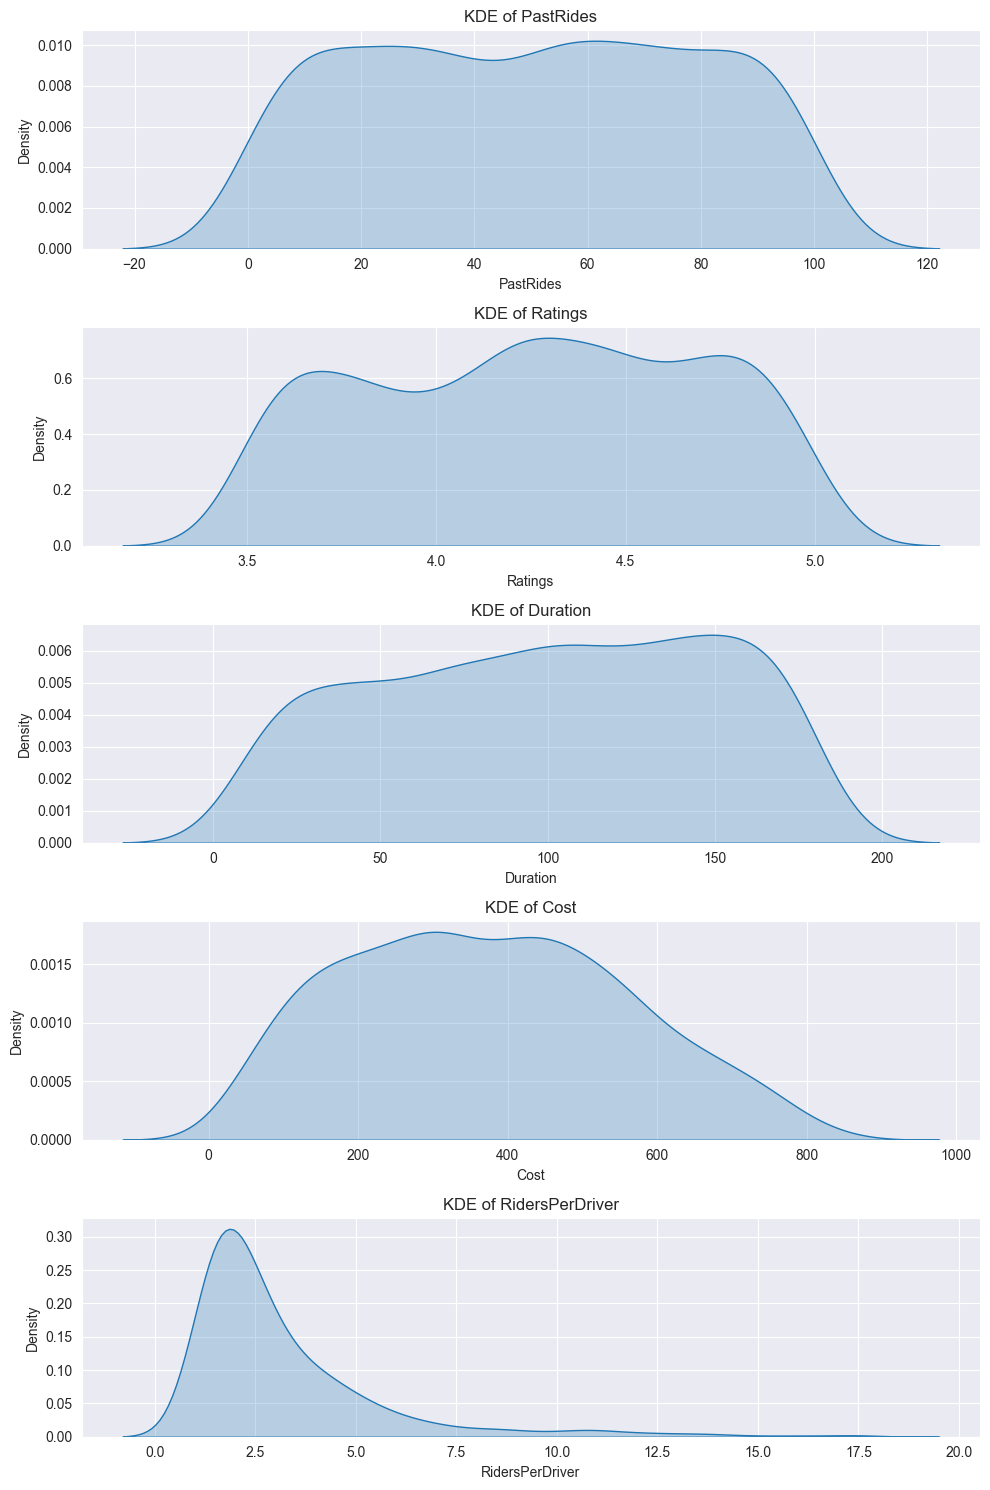

In [16]:
src['RidersPerDriver'] = pd.DataFrame(src['Riders'] / src['Drivers'],
                                      columns=['RidersPerDriver'])
src.drop(columns=['Riders', 'Drivers'], inplace=True)

# Let's see distributions of numerical columns. We'll use KDE plots for this.
numerical_columns = src.select_dtypes(include=['float64', 'int']).columns
# Create subplots
fig, axes = plt.subplots(nrows=len(numerical_columns), ncols=1, figsize=(10, 15))
for col, ax in zip(numerical_columns, axes):
    sns.kdeplot(data=src, x=col, ax=ax, fill=True)
    ax.set_title(f'KDE of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Density')
# Adjusting layout to prevent overlap
plt.tight_layout()
plt.show()

so looks like RidesPerDriver is skewed a lot and seems to have outliers (z>3).
We'll remove those outliers.

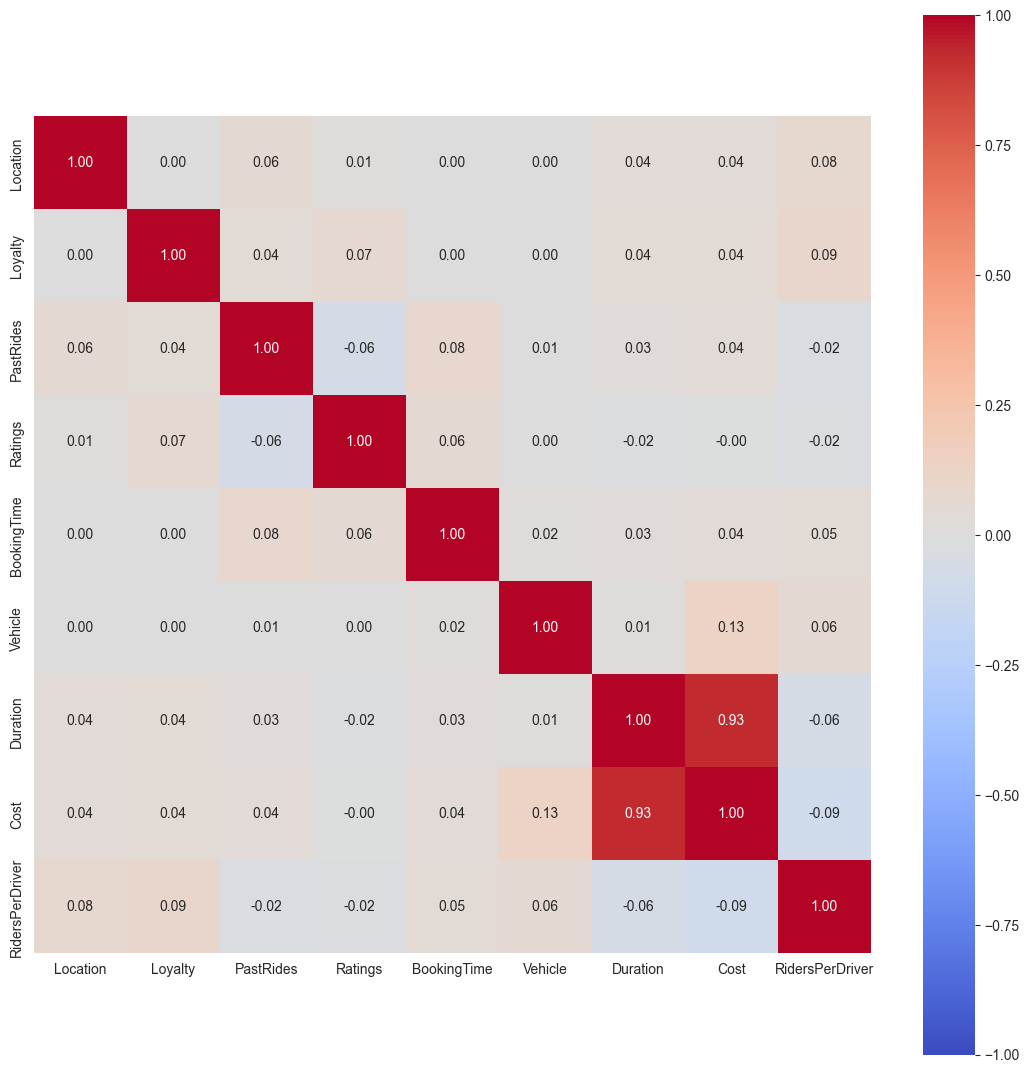

{'corr':                  Location   Loyalty  PastRides   Ratings  BookingTime  \
 Location         1.000000  0.000000   0.055912  0.014508     0.000000   
 Loyalty          0.000000  1.000000   0.041049  0.067979     0.000000   
 PastRides        0.055912  0.041049   1.000000 -0.064734     0.083151   
 Ratings          0.014508  0.067979  -0.064734  1.000000     0.056488   
 BookingTime      0.000000  0.000000   0.083151  0.056488     1.000000   
 Vehicle          0.000000  0.000000   0.005615  0.002523     0.022324   
 Duration         0.036065  0.040724   0.030679 -0.016968     0.027749   
 Cost             0.036418  0.040513   0.035859 -0.001063     0.037317   
 RidersPerDriver  0.077468  0.089419  -0.024869 -0.016468     0.046008   
 
                   Vehicle  Duration      Cost  RidersPerDriver  
 Location         0.000000  0.036065  0.036418         0.077468  
 Loyalty          0.000000  0.040724  0.040513         0.089419  
 PastRides        0.005615  0.030679  0.035859      

In [17]:
# Time for correlation plot. Since we have mix of numerical and categorical variables,
# standard data.corr() won't work here. We will use dython.nominal.associations instead.
dython.nominal.associations(src, plot=True, cmap='coolwarm')

In [18]:
# Duration and Cost have very high correlation (0.93). We will do PCA on these components.
scaler = StandardScaler()
src[['Duration', 'Cost']] = scaler.fit_transform(src[['Duration', 'Cost']])
pca = PCA(n_components=1)
pca_results = pca.fit_transform(src[['Duration', 'Cost']])
src.drop(columns=['Duration', 'Cost'], inplace=True)
src['DurationCostPCA'] = pca_results[:, 0]

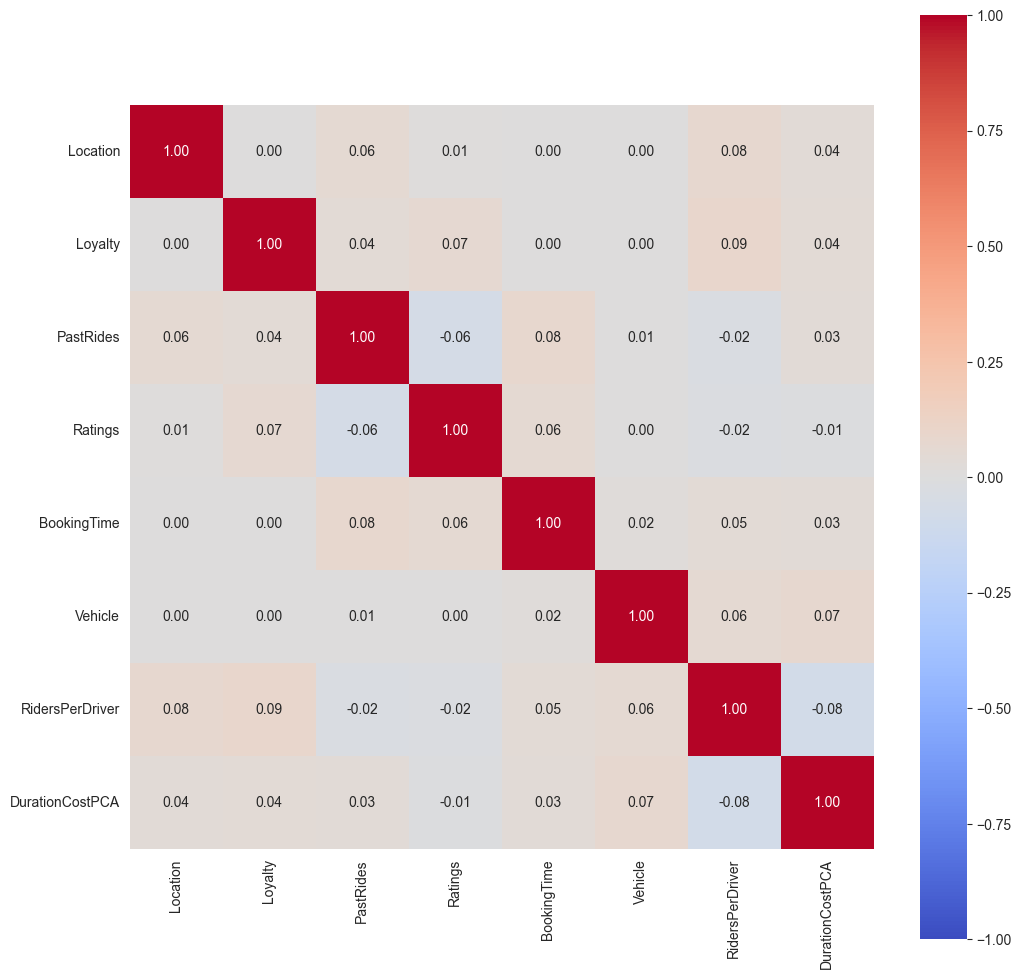

In [19]:
dython.nominal.associations(src, plot=True, cmap='coolwarm')
plt.show()

In [20]:
src['Loyalty'] = src['Loyalty'].map({
    'Regular': -1,
    'Silver': 0,
    'Gold': 1
}).astype(int)

In [21]:
label_encoder = LabelEncoder()
categorical_columns = src.select_dtypes(include=['object']).columns.values
for col in categorical_columns:
    src[col] = LabelEncoder().fit_transform(src[col])

In [22]:
import xgboost

In [23]:
xgb_model = xgboost.XGBRegressor()
feature_names = np.array(src.drop(columns=['DurationCostPCA']).columns)
X = src.drop(columns=['DurationCostPCA']).to_numpy()
y = src['DurationCostPCA'].to_numpy()
xgb_model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [24]:
xgb_model.predict(X)
score = xgb_model.score(X, y)
print(score)
for name, importance in zip(feature_names, xgb_model.feature_importances_):
    print(f'Feature: {name}, Importance: {importance}')

0.9786964161759419
Feature: Location, Importance: 0.08596457540988922
Feature: Loyalty, Importance: 0.10270065069198608
Feature: PastRides, Importance: 0.15942320227622986
Feature: Ratings, Importance: 0.17135533690452576
Feature: BookingTime, Importance: 0.1441868096590042
Feature: Vehicle, Importance: 0.14148563146591187
Feature: RidersPerDriver, Importance: 0.19488373398780823


In [25]:
from scipy.stats import zscore

# Calculate the z-scores of all numerical columns except the target variable
z_scores = np.abs(src.select_dtypes(include=[np.number]).drop(columns='DurationCostPCA').apply(zscore))

# Define a threshold and filter the dataset
threshold = 3
src = src[(z_scores < threshold).all(axis=1)]

In [26]:
X = src.drop(columns=['DurationCostPCA']).to_numpy()
y = src['DurationCostPCA'].to_numpy()
xgb_model.fit(X, y)
score = xgb_model.score(X, y)
print(score)
for name, importance in zip(feature_names, xgb_model.feature_importances_):
    print(f'Feature: {name}, Importance: {importance}')

0.9824994745062601
Feature: Location, Importance: 0.0722435787320137
Feature: Loyalty, Importance: 0.08951015025377274
Feature: PastRides, Importance: 0.15512293577194214
Feature: Ratings, Importance: 0.15615631639957428
Feature: BookingTime, Importance: 0.1679038554430008
Feature: Vehicle, Importance: 0.18158146739006042
Feature: RidersPerDriver, Importance: 0.1774817407131195
